In [1]:
from pulp import *
import pandas as pd
import numpy as np
import cvxpy  as cp
import matplotlib.pyplot as plt
import os

# Actividad 1

## Datos

##### Potencias mínimas

In [2]:
P1_min = 150 #[MW]
P2_min = 75 #[MW]
P3_min = 0 #[MW]

##### Potencias máximas

In [3]:
P1_max = 350 #[MW]
P2_max = 150 #[MW]
P3_max = 100 #[MW]

##### Costos fijos

In [4]:
cf1 = 1 #[$/h]
cf2 = 0.5 #[$/h]
cf3 = 0.1 #[$/h]

##### Costos variables

In [5]:
cv1 = 40 #[$/MWh]
cv2 = 75 #[$/MWh]
cv3 = 110 #[$/MWh]

##### Demanda

In [6]:
D = 500

## Problema de optmización primal:
### Minimización de costos

##### Inicialización del problema

In [7]:
prob = LpProblem("Primal", LpMinimize)

##### Definición de variables

In [8]:
P1 = LpVariable("P1")
P2 = LpVariable("P2")
P3 = LpVariable("P3")

##### Función objetivo

In [9]:
prob += (cf1 + cv1 * P1) + (cf2 + cv2 * P2) + (cf3 + cv3 * P3)

##### Restricciones

In [10]:
prob += (P1 + P2 + P3) == D # lambda
prob += - P1_min + P1 >= 0 # m1_min
prob += - P1 + P1_max >= 0 # m1_max
prob += - P2_min + P2 >= 0 # m2_min
prob += - P2 + P2_max >= 0 # m2_max
prob += - P3_min + P3 >= 0 # m3_min
prob += - P3 + P3_max >= 0 # m3_max

##### Resolución

In [11]:
prob.solve()

1

##### Estado de resolución del problema

In [12]:
print(LpStatus[prob.status])

Optimal


##### Potencias en el punto óptimo

In [13]:
for potencia in prob.variables():
    print(potencia.name , "=", potencia.varValue, "[MW]")

P1 = 350.0 [MW]
P2 = 150.0 [MW]
P3 = 0.0 [MW]


##### Costo total del sistema

In [14]:
print("Costo total = ", value(prob.objective), "[$]")

Costo total =  25251.6 [$]


##### Multiplicadores de Lagrange

In [15]:
for restriccion in prob.constraints.values():
    print("Variable dual para la restricción", restriccion, "->", restriccion.pi)

Variable dual para la restricción P1 + P2 + P3 = 500 -> 110.0
Variable dual para la restricción P1 >= 150 -> 0.0
Variable dual para la restricción -P1 >= -350 -> 70.0
Variable dual para la restricción P2 >= 75 -> 0.0
Variable dual para la restricción -P2 >= -150 -> 35.0
Variable dual para la restricción P3 >= 0 -> 0.0
Variable dual para la restricción -P3 >= -100 -> 0.0


## Problema de optmización dual:
### Maximización de los beneficios

##### Inicialización del problema

In [16]:
prob = LpProblem("Dual", LpMaximize)

##### Definición de variables

In [17]:
l = LpVariable("l")
m1_min = LpVariable("m1_min")
m1_max = LpVariable("m1_max")
m2_min = LpVariable("m2_min")
m2_max = LpVariable("m2_max")
m3_min = LpVariable("m3_min")
m3_max = LpVariable("m3_max")

##### Función objetivo

In [18]:
prob += D * l + (P1_min * m1_min + P2_min * m2_min + P3_min * m3_min) - (P1_max * m1_max + P2_max * m2_max + P3_max * m3_max)

##### Restricciones

In [19]:
prob += (l + m1_min - m1_max) - cv1 <= 0 # P1
prob += (l + m2_min - m2_max) - cv2 <= 0 # P2
prob += (l + m3_min - m3_max) - cv3 <= 0 # P3
prob += -m1_min <= 0
prob += -m1_max <= 0
prob += -m2_min <= 0
prob += -m2_max <= 0
prob += -m3_min <= 0
prob += -m3_max <= 0

##### Resolución

In [20]:
prob.solve()

1

##### Estado de resolución del problema

In [21]:
print(LpStatus[prob.status])

Optimal


##### Multiplicadores de Lagrange en el punto óptimo

In [22]:
for m in prob.variables():
    print(m.name , "=", m.varValue, "[$/MWh]")

l = 75.0 [$/MWh]
m1_max = 35.0 [$/MWh]
m1_min = -0.0 [$/MWh]
m2_max = -0.0 [$/MWh]
m2_min = -0.0 [$/MWh]
m3_max = -0.0 [$/MWh]
m3_min = -0.0 [$/MWh]


##### Beneficio total del sistema

In [23]:
print("Beneficio total = ", value(prob.objective), "[$]")

Beneficio total =  25250.0 [$]


##### Multiplicadores de Lagrange

In [24]:
for restriccion in prob.constraints.values():
    print("Variable dual para la restricción", restriccion, "->", restriccion.pi)

Variable dual para la restricción l - m1_max + m1_min <= 40 -> 350.0
Variable dual para la restricción l - m2_max + m2_min <= 75 -> 150.0
Variable dual para la restricción l - m3_max + m3_min <= 110 -> -0.0
Variable dual para la restricción -m1_min <= 0 -> 200.0
Variable dual para la restricción -m1_max <= 0 -> -0.0
Variable dual para la restricción -m2_min <= 0 -> 75.0
Variable dual para la restricción -m2_max <= 0 -> 0.0
Variable dual para la restricción -m3_min <= 0 -> -0.0
Variable dual para la restricción -m3_max <= 0 -> 100.0


# Actividad 2

## Datos

### Generadores

In [25]:
Datos_gen = pd.read_excel("Datos_gen.xlsx", sheet_name="Datos_gen", index_col=0)
Datos_gen

,Pmax,Pmin,Coef_a,Coef_b,Coef_c,Cost. comb.,Unnamed: 7,Unnamed: 8
Gen Number,,,,,,,,
1,500,150,2000,25,0.05,1,NaN,H1 = coef_a + coef_bP1 + coef_cP12
2,700,200,1250,15,0.04,1,NaN,NaN
3,200,0,1700,10,0.03,1,NaN,NaN


#### Potencias mínimas

In [26]:
P1_min = Datos_gen.loc[1, "Pmin"] #[MW]
P2_min = Datos_gen.loc[2, "Pmin"] #[MW]
P3_min = Datos_gen.loc[3, "Pmin"] #[MW]
print("P1_min = {}".format(P1_min))
print("P2_min = {}".format(P2_min))
print("P3_min = {}".format(P3_min))

P1_min = 150
P2_min = 200
P3_min = 0


#### Potencias máximas

In [27]:
P1_max = Datos_gen.loc[1, "Pmax"] #[MW]
P2_max = Datos_gen.loc[2, "Pmax"] #[MW]
P3_max = Datos_gen.loc[3, "Pmax"] #[MW]
print("P1_max = {}".format(P1_max))
print("P2_max = {}".format(P2_max))
print("P3_max = {}".format(P3_max))

P1_max = 500
P2_max = 700
P3_max = 200


#### Función de costo

In [28]:
a1 = Datos_gen.loc[1, "Coef_a"]
b1 = Datos_gen.loc[1, "Coef_b"]
c1 = Datos_gen.loc[1, "Coef_c"]
a2 = Datos_gen.loc[2, "Coef_a"]
b2 = Datos_gen.loc[2, "Coef_b"]
c2 = Datos_gen.loc[2, "Coef_c"]
a3 = Datos_gen.loc[3, "Coef_a"]
b3 = Datos_gen.loc[3, "Coef_b"]
c3 = Datos_gen.loc[3, "Coef_c"]
print("C1 = {} + {} * P1 + {} * P1 ** 2".format(a1, b1, c1))
print("C2 = {} + {} * P2 + {} * P2 ** 2".format(a2, b2, c2))
print("C3 = {} + {} * P3 + {} * P3 ** 2".format(a3, b3, c3))

C1 = 2000 + 25 * P1 + 0.05 * P1 ** 2
C2 = 1250 + 15 * P2 + 0.04 * P2 ** 2
C3 = 1700 + 10 * P3 + 0.03 * P3 ** 2


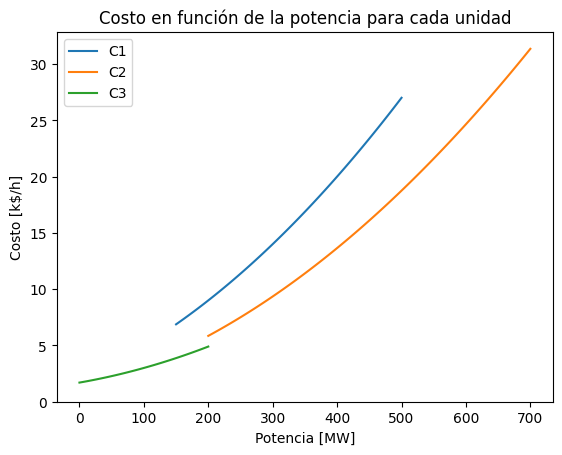

In [29]:
def C1(P):
    # if P >= P1_min and P <= P1_max:
    return a1 + b1 * P + c1 * P ** 2
def C2(P):
    return a2 + b2 * P + c2 * P ** 2
def C3(P):
    return a3 + b3 * P + c3 * P ** 2
cant_ptos = 100
P1 = np.linspace(P1_min, P1_max, cant_ptos)
P2 = np.linspace(P2_min, P2_max, cant_ptos)
P3 = np.linspace(P3_min, P3_max, cant_ptos)
C1 = C1(P1)
C2 = C2(P2)
C3 = C3(P3)

# P = np.linspace(0, 700, cant_ptos)
# C1 = C1(P)
# C2 = C2(P)
# C3 = C3(P)
plt.plot(P1, C1 / 1000, label="C1")
plt.plot(P2, C2 / 1000, label="C2")
plt.plot(P3, C3 / 1000, label="C3")
plt.legend()
plt.ylim([0, None])
plt.xlabel("Potencia [MW]")
plt.ylabel("Costo [k$/h]")
plt.title("Costo en función de la potencia para cada unidad")
dir = "Graficos"
if not os.path.exists(dir):
    os.mkdir(dir)
plt.savefig("{}/CostoGeneradores.jpg".format(dir), dpi=300, bbox_inches="tight")
plt.show()

### Demanda

In [30]:
Perfil_horario = pd.read_excel("Datos_gen.xlsx", sheet_name="Perfil_horario", index_col=0)
horas = Perfil_horario.index.values
Perfil_horario

,Demanda
Hora,
1,836.92
2,805.56
3,786.94
4,781.06
5,783.02
6,794.78
7,847.70
8,903.56
9,951.58


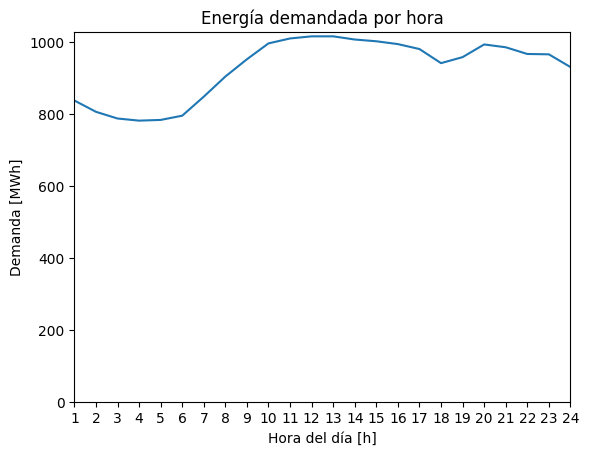

In [31]:
plt.plot(Perfil_horario)
plt.xlabel("Hora del día [h]")
plt.ylabel("Demanda [MWh]")
plt.xlim([1, 24])
plt.ylim(0)
plt.xticks(list(range(1,25)))
plt.title("Energía demandada por hora")
plt.show()

### Líneas de transmisión

In [32]:
Transmision = pd.read_excel("Datos_gen.xlsx", sheet_name="Transmision", index_col=0)
Transmision

,B1-B2,B2-B3,B1-B3,Unnamed: 4,Unnamed: 5,Unnamed: 6
Linea,,,,,,
Capacidad,220.0,280.0,100,MW,NaN,NaN
Reactancia,0.5,0.6,1,pu,100 MVA,220 kV


### Flujo mínimo

In [33]:
P12_min = - Transmision.loc["Capacidad", "B1-B2"]
# P12_min = - 100
P23_min = - Transmision.loc["Capacidad", "B2-B3"]
P13_min = - Transmision.loc["Capacidad", "B1-B3"]
print("P12_min = {}".format(P12_min))
print("P23_min = {}".format(P23_min))
print("P13_min = {}".format(P13_min))

P12_min = -220.0
P23_min = -280.0
P13_min = -100


### Flujo máximo

In [34]:
P12_max = - P12_min
P23_max = - P23_min
P13_max = - P13_min
print("P12_max = {}".format(P12_max))
print("P23_max = {}".format(P23_max))
print("P13_max = {}".format(P13_max))

P12_max = 220.0
P23_max = 280.0
P13_max = 100


### Reactancias

In [35]:
Zb = 220 ** 2 / 100
X12 = 0.5 * Zb
X23 = 0.6 * Zb
X13 = 1 * Zb
print("X12 = {}".format(X12))
print("X23 = {}".format(X23))
print("X13 = {}".format(X13))

X12 = 242.0
X23 = 290.4
X13 = 484.0


In [36]:
lista_Pg = [] # Generaciones
lista_C =  [] # Costo total
lista_ml = [] # Multiplicadores de Lagrange
lista_Pl = [] # Flujos por las líneas
lista_t = [] # Ángulos de las barras

## Escenario 1

In [37]:
Pg_dia = np.zeros((24, 3))
C_dia = np.zeros((24, 1))
ml_dia = np.zeros((24, 7))
for idx, D in zip(Perfil_horario.index, Perfil_horario["Demanda"]):
    idx = idx - 1
    # Definción de variables
    P1 = cp.Variable(name="P1")
    P2 = cp.Variable(name="P2")
    P3 = cp.Variable(name="P3")
    # Función objetivo
    Pg = np.array([P1, P2, P3])
    a = np.array([a1, a2, a3])
    b = np.array([b1, b2, b3])
    c = np.array([c1, c2, c3])
    C = sum(a) + b @ Pg + c @ Pg ** 2
    # Balance de potencia en la barra (l)
    rest_lck = [- P1 - P2 - P3 == - D]
    # Límite de los generadores (mi_min, mi_max)
    rest_gen_min_max = [P1 - P1_min >= 0,
                        P1_max - P1 >= 0,
                        P2 - P2_min >= 0,
                        P2_max - P2 >= 0,
                        P3 - P3_min >= 0,
                        P3_max - P3 >= 0]
    # Restricciones
    restricciones = rest_lck + rest_gen_min_max
    # Inicialización del problema
    prob = cp.Problem(cp.Minimize(C), restricciones)
    # Resolución
    prob.solve()
    # Generaciones en el punto óptimo
    Pg = np.array([P1.value.item(), P2.value.item(), P3.value.item()])
    Pg_dia[idx, :] = Pg
    # Costo total del sistema
    C = C.value.item()
    C_dia[idx] = C / 1000
    # Multiplicadores de Lagrange
    ml = np.array([rest.dual_value.tolist() for rest in restricciones])
    ml_dia[idx] = ml
Pg_dia = pd.DataFrame(Pg_dia, index=horas, columns=["G1", "G2", "G3"])
ml_dia = pd.DataFrame(ml_dia, index=horas, columns=["l", "m1_min", "m1_max", "m2_min", "m2_max", "m3_min", "m3_max"])

In [38]:
lista_Pg.append(Pg_dia)
lista_C.append(C_dia)
lista_ml.append(ml_dia)
lista_Pl.append(None)
lista_t.append(None)

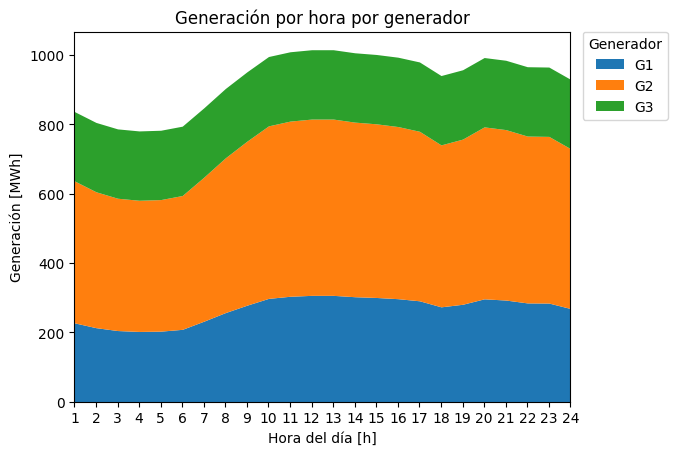

In [39]:
Pg_dia.plot.area(linewidth=0)
plt.xlabel("Hora del día [h]")
plt.ylabel("Generación [MWh]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Generación por hora por generador")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Generador")
plt.show()

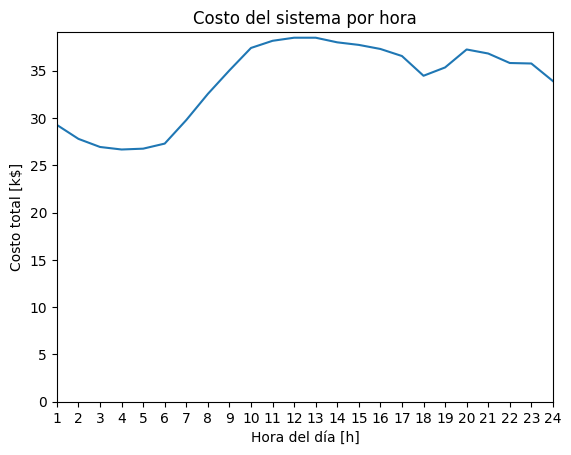

In [40]:
plt.plot(horas, C_dia)
plt.xlabel("Hora del día [h]")
plt.ylabel("Costo total [k$]")
plt.xlim([1, 24])
plt.ylim(0)
plt.xticks(list(range(1,25)))
plt.title("Costo del sistema por hora")
plt.show()

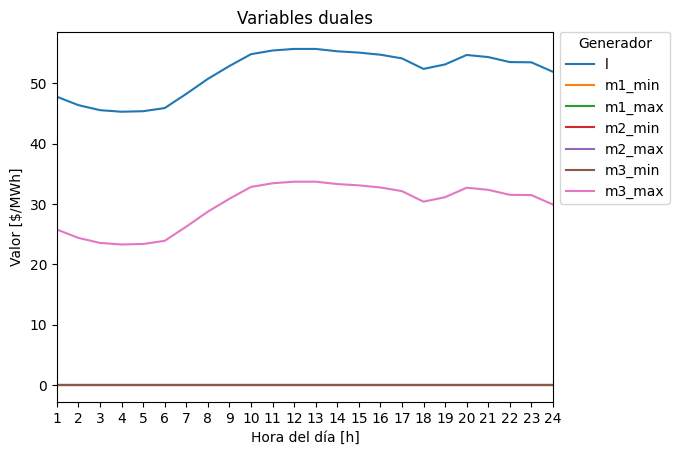

In [41]:
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
ml_dia.plot(color=colores)
plt.xlabel("Hora del día [h]")
plt.ylabel("Valor [$/MWh]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Variables duales")
plt.legend(bbox_to_anchor=(1.25, 1.02), loc="upper right", title="Generador")
plt.show()

## Escenario 2

In [42]:
Pg_dia = np.zeros((24, 3)) # Generaciones
C_dia = np.zeros((24, 1)) # Costo total
ml_dia = np.zeros((24, 12)) # Multiplicadores de Lagrange
Pl_dia = np.zeros((24, 3)) # Flujos por las líneas
t_dia = np.zeros((24, 3)) # Ángulos de las barras
L_dia = np.zeros((24, 3)) # Pérdidas de las líneas
for idx, D in zip(Perfil_horario.index, Perfil_horario["Demanda"]):
    idx = idx - 1
    # Definción de variables
        # Generaciones
    P1 = cp.Variable(name="P1")
    P2 = cp.Variable(name="P2")
    P3 = cp.Variable(name="P3")
        # Flujos
    P12 = cp.Variable(name="P12")
    P13 = cp.Variable(name="P13")
    P23 = cp.Variable(name="P23")
        # Ángulos
    t1 = 0 #cp.Variable(name="t1")
    t2 = cp.Variable(name="t2")
    t3 = cp.Variable(name="t3")
        # Pérdidas
    L12 = cp.Variable(name="L12")
    L13 = cp.Variable(name="L13")
    L23 = cp.Variable(name="L23")
    # Función objetivo
    Pg = np.array([P1, P2, P3])
    a = np.array([a1, a2, a3])
    b = np.array([b1, b2, b3])
    c = np.array([c1, c2, c3])
    C = sum(a) + b @ Pg + c @ Pg ** 2
    # Balance de potencia en las barras (l1, l2 y l3)
    D1 = 0.6 * D
    D2 = 0.3 * D
    D3 = 0.1 * D
    D1 = D / 3
    D2 = D / 3
    D3 = D / 3
    rest_lck = [-P1 + P12 + P13 == -D1 - (L12 + L13) / 2,
                -P2 - P12 + P23 == -D2 - (L12 + L23) / 2,
                -P3 - P13 - P23 == -D3 - (L13 + L23) / 2]
    # Límite de los generadores (mi_min, mi_max)
    rest_gen_min_max = [P1 - P1_min >= 0,
                        P1_max - P1 >= 0,
                        P2 - P2_min >= 0,
                        P2_max - P2 >= 0,
                        P3 - P3_min >= 0,
                        P3_max - P3 >= 0]
    # Cálculo del flujo por las líneas (l4, l5, l6)
    rest_calc_flujo = [- P12 == - 220 ** 2 * (t1 - t2) / X12,
                       - P13 == - 220 ** 2 * (t1 - t3) / X13,
                       - P23 == - 220 ** 2 * (t2 - t3) / X23]
    # Cálculo de las pérdidas (mij_loss_min, mij_loss_max)
    rest_calc_perdidas = [L12 >= P12 * 0.03,
                          L12 >= - P12 * 0.03,
                          L13 >= P13 * 0.03,
                          L13 >= - P13 * 0.03,
                          L23 >= P23 * 0.03,
                          L23 >= - P23 * 0.03]
    # Restricciones
    restricciones = rest_lck + rest_gen_min_max + rest_calc_flujo + rest_calc_perdidas
    restricciones_sin_perdidas = rest_lck + rest_gen_min_max + rest_calc_flujo
    # Inicialización del problema
    prob = cp.Problem(cp.Minimize(C), restricciones)
    # Resolución
    prob.solve()
    # Generaciones en el punto óptimo
    Pg = np.array([P1.value.item(), P2.value.item(), P3.value.item()])
    Pg_dia[idx, :] = Pg
    # Costo total del sistema
    C = C.value.item()
    C_dia[idx] = C / 1000
    # Multiplicadores de Lagrange
    ml = np.array([rest.dual_value.tolist() for rest in restricciones_sin_perdidas])
    ml_dia[idx] = ml
    # Flujos en el punto óptimo
    Pl = np.array([P12.value.item(), P13.value.item(), P23.value.item()])
    Pl_dia[idx, :] = Pl
    # Ángulos en el punto óptimo
    t = np.array([t1, t2.value.item(), t3.value.item()])
    t_dia[idx, :] = t
Pg_dia = pd.DataFrame(Pg_dia, index=horas, columns=["G1", "G2", "G3"])
ml_dia = pd.DataFrame(ml_dia, index=horas, columns=["l1", "l2", "l3", "m1_min", "m1_max", "m2_min", "m2_max", "m3_min", "m3_max", "l4", "l5", "l6"])
Pl_dia = pd.DataFrame(Pl_dia, index=horas, columns=["L12", "L13", "L23"])
t_dia = pd.DataFrame(t_dia * 180 / 3.1416, index=horas, columns=["B1", "B2", "B3"])

In [43]:
lista_Pg.append(Pg_dia)
lista_C.append(C_dia)
lista_ml.append(ml_dia)
lista_Pl.append(Pl_dia)
lista_t.append(t_dia)

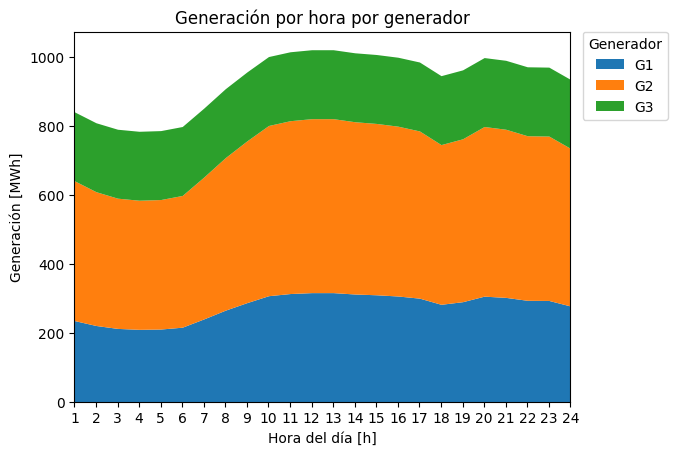

In [44]:
Pg_dia.plot.area(linewidth=0)
plt.xlabel("Hora del día [h]")
plt.ylabel("Generación [MWh]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Generación por hora por generador")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Generador")
plt.show()

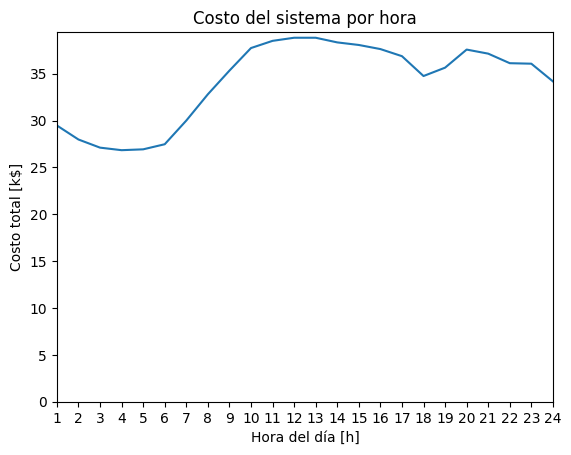

In [45]:
plt.plot(horas, C_dia)
plt.xlabel("Hora del día [h]")
plt.ylabel("Costo total [k$]")
plt.xlim([1, 24])
plt.ylim(0)
plt.xticks(list(range(1,25)))
plt.title("Costo del sistema por hora")
plt.show()

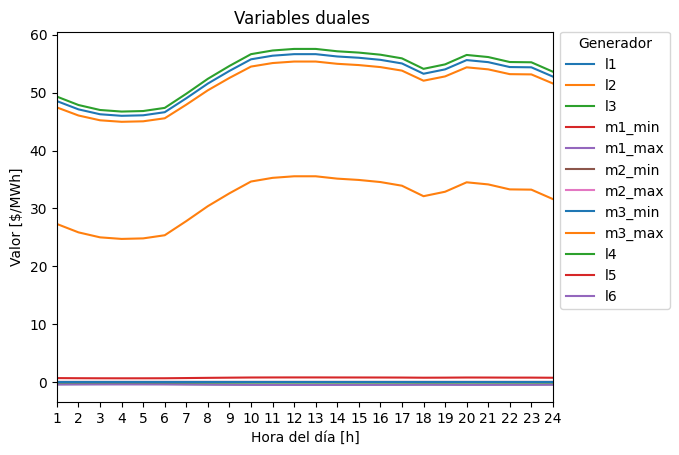

In [46]:
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
ml_dia.plot(color=colores)
plt.xlabel("Hora del día [h]")
plt.ylabel("Valor [$/MWh]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Variables duales ")
plt.legend(bbox_to_anchor=(1.25, 1.02), loc="upper right", title="Generador")
plt.show()

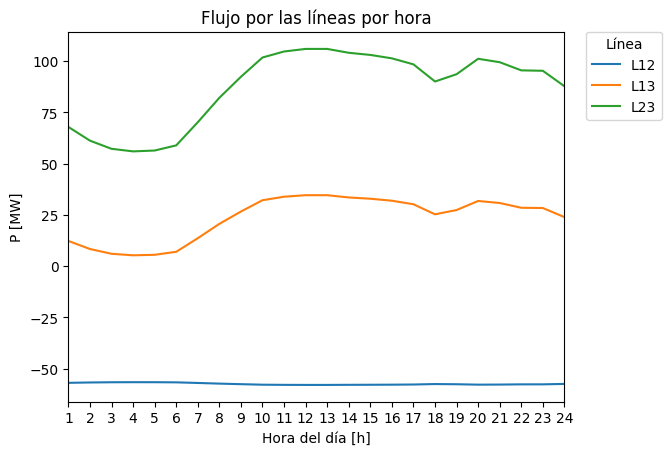

In [47]:
Pl_dia.plot()
plt.xlabel("Hora del día [h]")
plt.ylabel("P [MW]")
plt.xlim([1, 24])
# plt.ylim([None,0])
plt.xticks(list(range(1,25)))
plt.title("Flujo por las líneas por hora")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Línea")
plt.show()

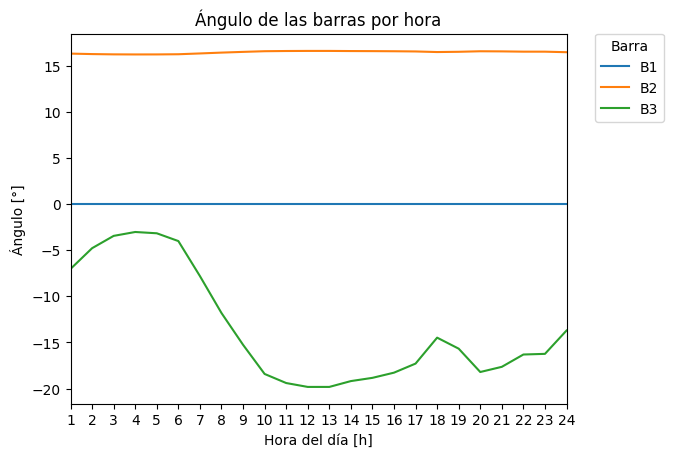

In [48]:
t_dia.plot()
plt.xlabel("Hora del día [h]")
plt.ylabel("Ángulo [°]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Ángulo de las barras por hora")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Barra")
plt.show()

## Escenario 3

In [49]:
Pg_dia = np.zeros((24, 3)) # Generaciones
C_dia = np.zeros((24, 1)) # Costo total
ml_dia = np.zeros((24, 18)) # Multiplicadores de Lagrange
Pl_dia = np.zeros((24, 3)) # Flujos por las líneas
t_dia = np.zeros((24, 3)) # Ángulos de las barras
for idx, D in zip(Perfil_horario.index, Perfil_horario["Demanda"]):
    idx = idx - 1
    # Definción de variables
        # Generaciones
    P1 = cp.Variable(name="P1")
    P2 = cp.Variable(name="P2")
    P3 = cp.Variable(name="P3")
        # Flujos
    P12 = cp.Variable(name="P12")
    P13 = cp.Variable(name="P13")
    P23 = cp.Variable(name="P23")
        # Ángulos
    t1 = 0 #cp.Variable(name="t1")
    t2 = cp.Variable(name="t2")
    t3 = cp.Variable(name="t3")
        # Pérdidas
    L12 = cp.Variable(name="L12")
    L13 = cp.Variable(name="L13")
    L23 = cp.Variable(name="L23")
    # Función objetivo
    Pg = np.array([P1, P2, P3])
    a = np.array([a1, a2, a3])
    b = np.array([b1, b2, b3])
    c = np.array([c1, c2, c3])
    C = sum(a) + b @ Pg + c @ Pg ** 2
    # Balance de potencia en las barras (l1, l2 y l3)
    D1 = 0.6 * D
    D2 = 0.3 * D
    D3 = 0.1 * D
#     D1 = D / 3
#     D2 = D / 3
#     D3 = D / 3
    rest_lck = [-P1 + P12 + P13 == -D1 - (L12 + L13) / 2,
                -P2 - P12 + P23 == -D2 - (L12 + L23) / 2,
                -P3 - P13 - P23 == -D3 - (L13 + L23) / 2]
    # Límite de los generadores (mi_min, mi_max)
    rest_gen_min_max = [P1 - P1_min >= 0,
                        P1_max - P1 >= 0,
                        P2 - P2_min >= 0,
                        P2_max - P2 >= 0,
                        P3 - P3_min >= 0,
                        P3_max - P3 >= 0]
    # Límite de los flujos (mij_min, mij_max)
    rest_flujo_min_max = [P12 - P12_min >= 0,
                        P12_max - P12 >= 0,
                        P13 - P13_min >= 0,
                        P13_max - P13 >= 0,
                        P23 - P23_min >= 0,
                        P23_max - P23 >= 0]
    # Cálculo del flujo por las líneas (l4, l5, l6)
    rest_calc_flujo = [- P12 == - 220 ** 2 * (t1 - t2) / X12,
                       - P13 == - 220 ** 2 * (t1 - t3) / X13,
                       - P23 == - 220 ** 2 * (t2 - t3) / X23]
    # Cálculo de las pérdidas (mij_loss_min, mij_loss_max)
    rest_calc_perdidas = [L12 >= P12 * 0.03,
                          L12 >= - P12 * 0.03,
                          L13 >= P13 * 0.03,
                          L13 >= - P13 * 0.03,
                          L23 >= P23 * 0.03,
                          L23 >= - P23 * 0.03]
    # Restricciones
    restricciones = rest_lck + rest_gen_min_max + rest_flujo_min_max + rest_calc_flujo + rest_calc_perdidas
    restricciones_sin_perdidas = rest_lck + rest_gen_min_max + rest_flujo_min_max + rest_calc_flujo
    # Inicialización del problema
    prob = cp.Problem(cp.Minimize(C), restricciones)
    # Resolución
    prob.solve()
    # Generaciones en el punto óptimo
    Pg = np.array([P1.value.item(), P2.value.item(), P3.value.item()])
    Pg_dia[idx, :] = Pg
    # Costo total del sistema
    C = C.value.item()
    C_dia[idx] = C / 1000
    # Multiplicadores de Lagrange
    ml = np.array([rest.dual_value.tolist() for rest in restricciones_sin_perdidas])
    ml_dia[idx] = ml
    # Flujos en el punto óptimo
    Pl = np.array([P12.value.item(), P13.value.item(), P23.value.item()])
    Pl_dia[idx, :] = Pl
    # Ángulos en el punto óptimo
    t = np.array([t1, t2.value.item(), t3.value.item()])
    t_dia[idx, :] = t
Pg_dia = pd.DataFrame(Pg_dia, index=horas, columns=["G1", "G2", "G3"])
ml_dia = pd.DataFrame(ml_dia, index=horas, columns=["l1", "l2", "l3", "m1_min", "m1_max", "m2_min", "m2_max", "m3_min", "m3_max", "m12_min", "m12_max", "m13_min", "m13_max", "m23_min", "m23_max", "l4", "l5", "l6"])
Pl_dia = pd.DataFrame(Pl_dia, index=horas, columns=["L12", "L13", "L23"])
t_dia = pd.DataFrame(t_dia * 180 / 3.1416, index=horas, columns=["B1", "B2", "B3"])

In [50]:
lista_Pg.append(Pg_dia)
lista_C.append(C_dia)
lista_ml.append(ml_dia)
lista_Pl.append(Pl_dia)
lista_t.append(t_dia)

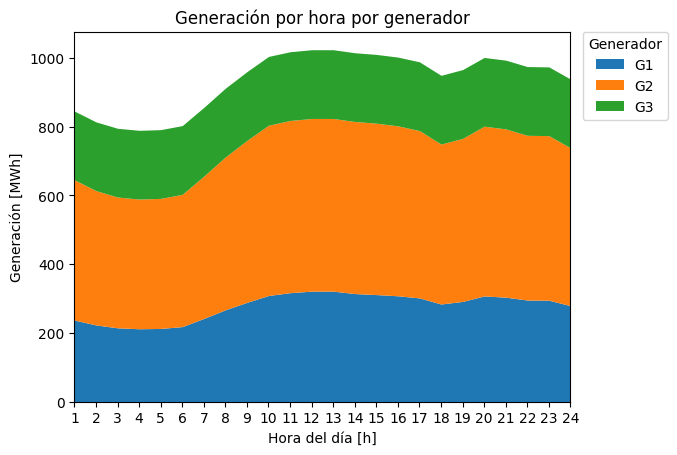

In [51]:
Pg_dia.plot.area(linewidth=0)
plt.xlabel("Hora del día [h]")
plt.ylabel("Generación [MWh]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Generación por hora por generador")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Generador")
plt.show()

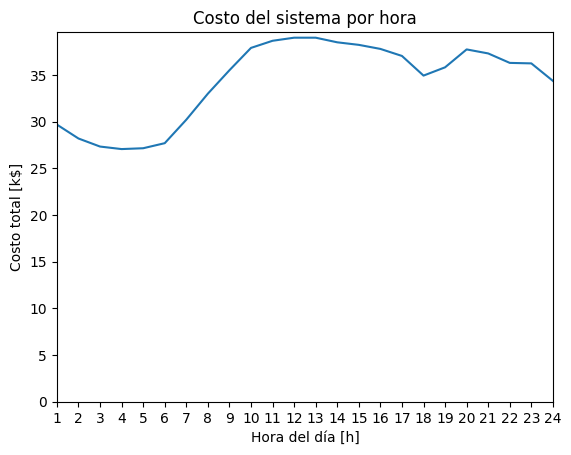

In [52]:
plt.plot(horas, C_dia)
plt.xlabel("Hora del día [h]")
plt.ylabel("Costo total [k$]")
plt.xlim([1, 24])
plt.ylim(0)
plt.xticks(list(range(1,25)))
plt.title("Costo del sistema por hora")
plt.show()

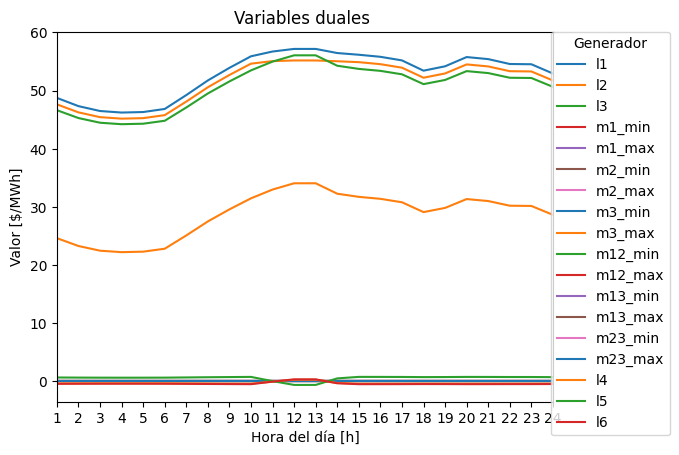

In [53]:
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
ml_dia.plot(color=colores)
plt.xlabel("Hora del día [h]")
plt.ylabel("Valor [$/MWh]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Variables duales ")
plt.legend(bbox_to_anchor=(1.25, 1.02), loc="upper right", title="Generador")
plt.show()

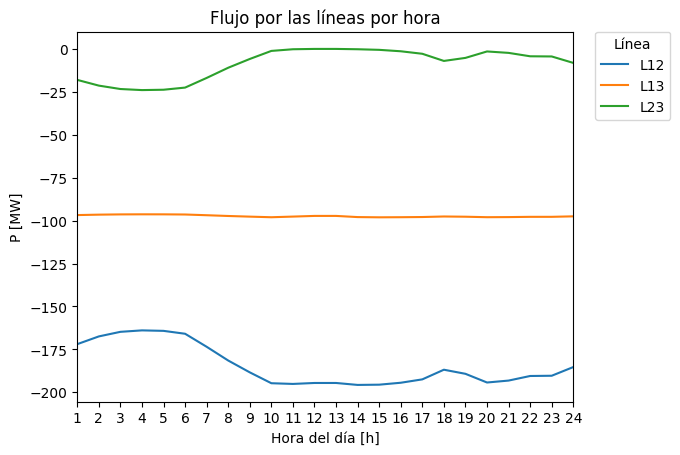

In [54]:
Pl_dia.plot()
plt.xlabel("Hora del día [h]")
plt.ylabel("P [MW]")
plt.xlim([1, 24])
# plt.ylim([None,0])
plt.xticks(list(range(1,25)))
plt.title("Flujo por las líneas por hora")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Línea")
plt.show()

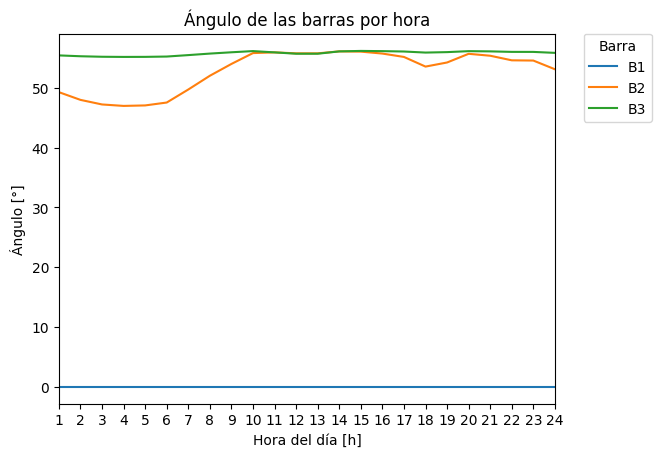

In [55]:
t_dia.plot()
plt.xlabel("Hora del día [h]")
plt.ylabel("Ángulo [°]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Ángulo de las barras por hora")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Barra")
plt.show()

## Escenario 4

In [56]:
Pg_dia = np.zeros((24, 3)) # Generaciones
C_dia = np.zeros((24, 1)) # Costo total
ml_dia = np.zeros((24, 18)) # Multiplicadores de Lagrange
Pl_dia = np.zeros((24, 3)) # Flujos por las líneas
t_dia = np.zeros((24, 3)) # Ángulos de las barras
for idx, D in zip(Perfil_horario.index, Perfil_horario["Demanda"]):
    idx = idx - 1
    # Definción de variables
        # Generaciones
    P1 = cp.Variable(name="P1")
    P2 = cp.Variable(name="P2")
    P3 = cp.Variable(name="P3")
        # Flujos
    P12 = cp.Variable(name="P12")
    P13 = cp.Variable(name="P13")
    P23 = cp.Variable(name="P23")
        # Ángulos
    t1 = 0 #cp.Variable(name="t1")
    t2 = cp.Variable(name="t2")
    t3 = cp.Variable(name="t3")
        # Pérdidas
    L12 = cp.Variable(name="L12")
    L13 = cp.Variable(name="L13")
    L23 = cp.Variable(name="L23")
    # Función objetivo
    Pg = np.array([P1, P2, P3])
    a = np.array([a1, a2, a3])
    b = np.array([b1, b2, b3])
    c = np.array([c1, c2, c3])
    C = (sum(a) + b @ Pg + c @ Pg ** 2) * 3
    # Balance de potencia en las barras (l1, l2 y l3)
    D1 = 0.6 * D
    D2 = 0.3 * D
    D3 = 0.1 * D
#     D1 = D / 3
#     D2 = D / 3
#     D3 = D / 3
    rest_lck = [-P1 + P12 + P13 == -D1 - (L12 + L13) / 2,
                -P2 - P12 + P23 == -D2 - (L12 + L23) / 2,
                -P3 - P13 - P23 == -D3 - (L13 + L23) / 2]
    # Límite de los generadores (mi_min, mi_max)
    rest_gen_min_max = [P1 - P1_min >= 0,
                        P1_max - P1 >= 0,
                        P2 - P2_min >= 0,
                        P2_max - P2 >= 0,
                        P3 - P3_min >= 0,
                        P3_max - P3 >= 0]
    # Límite de los flujos (mij_min, mij_max)
    rest_flujo_min_max = [P12 - P12_min >= 0,
                        P12_max - P12 >= 0,
                        P13 - P13_min >= 0,
                        P13_max - P13 >= 0,
                        P23 - P23_min >= 0,
                        P23_max - P23 >= 0]
    # Cálculo del flujo por las líneas (l4, l5, l6)
    rest_calc_flujo = [- P12 == - 220 ** 2 * (t1 - t2) / X12,
                       - P13 == - 220 ** 2 * (t1 - t3) / X13,
                       - P23 == - 220 ** 2 * (t2 - t3) / X23]
    # Cálculo de las pérdidas (mij_loss_min, mij_loss_max)
    rest_calc_perdidas = [L12 >= P12 * 0.03,
                          L12 >= - P12 * 0.03,
                          L13 >= P13 * 0.03,
                          L13 >= - P13 * 0.03,
                          L23 >= P23 * 0.03,
                          L23 >= - P23 * 0.03]
    # Restricciones
    restricciones = rest_lck + rest_gen_min_max + rest_flujo_min_max + rest_calc_flujo + rest_calc_perdidas
    restricciones_sin_perdidas = rest_lck + rest_gen_min_max + rest_flujo_min_max + rest_calc_flujo
    # Inicialización del problema
    prob = cp.Problem(cp.Minimize(C), restricciones)
    # Resolución
    prob.solve()
    # Generaciones en el punto óptimo
    Pg = np.array([P1.value.item(), P2.value.item(), P3.value.item()])
    Pg_dia[idx, :] = Pg
    # Costo total del sistema
    C = C.value.item()
    C_dia[idx] = C / 1000
    # Multiplicadores de Lagrange
    ml = np.array([rest.dual_value.tolist() for rest in restricciones_sin_perdidas])
    ml_dia[idx] = ml
    # Flujos en el punto óptimo
    Pl = np.array([P12.value.item(), P13.value.item(), P23.value.item()])
    Pl_dia[idx, :] = Pl
    # Ángulos en el punto óptimo
    t = np.array([t1, t2.value.item(), t3.value.item()])
    t_dia[idx, :] = t
Pg_dia = pd.DataFrame(Pg_dia, index=horas, columns=["G1", "G2", "G3"])
ml_dia = pd.DataFrame(ml_dia, index=horas, columns=["l1", "l2", "l3", "m1_min", "m1_max", "m2_min", "m2_max", "m3_min", "m3_max", "m12_min", "m12_max", "m13_min", "m13_max", "m23_min", "m23_max", "l4", "l5", "l6"])
Pl_dia = pd.DataFrame(Pl_dia, index=horas, columns=["L12", "L13", "L23"])
t_dia = pd.DataFrame(t_dia * 180 / 3.1416, index=horas, columns=["B1", "B2", "B3"])

In [57]:
lista_Pg.append(Pg_dia)
lista_C.append(C_dia)
lista_ml.append(ml_dia)
lista_Pl.append(Pl_dia)
lista_t.append(t_dia)

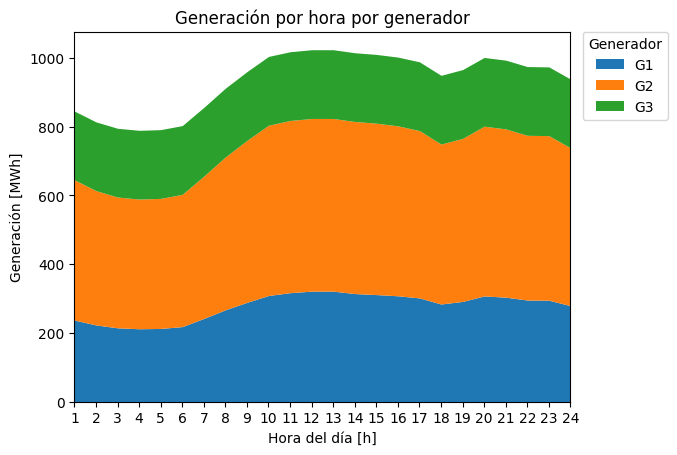

In [58]:
Pg_dia.plot.area(linewidth=0)
plt.xlabel("Hora del día [h]")
plt.ylabel("Generación [MWh]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Generación por hora por generador")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Generador")
plt.show()

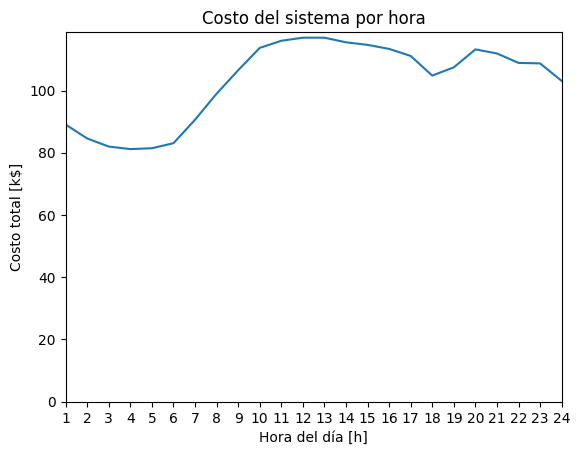

In [59]:
plt.plot(horas, C_dia)
plt.xlabel("Hora del día [h]")
plt.ylabel("Costo total [k$]")
plt.xlim([1, 24])
plt.ylim(0)
plt.xticks(list(range(1,25)))
plt.title("Costo del sistema por hora")
plt.show()

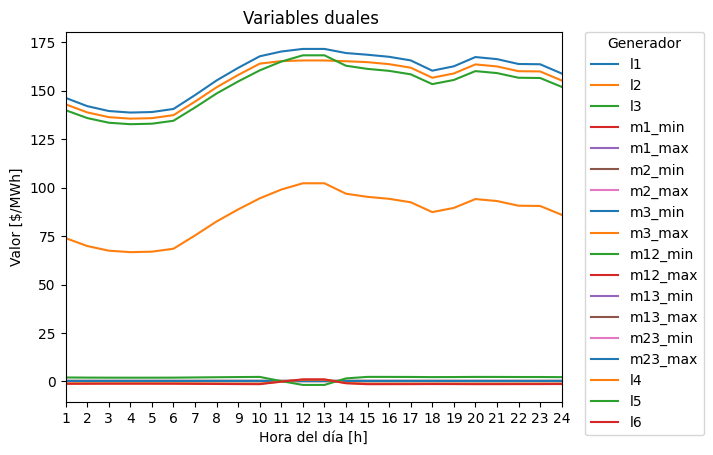

In [60]:
colores = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
ml_dia.plot(color=colores)
plt.xlabel("Hora del día [h]")
plt.ylabel("Valor [$/MWh]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Variables duales ")
plt.legend(bbox_to_anchor=(1.3, 1.02), loc="upper right", title="Generador")
plt.show()

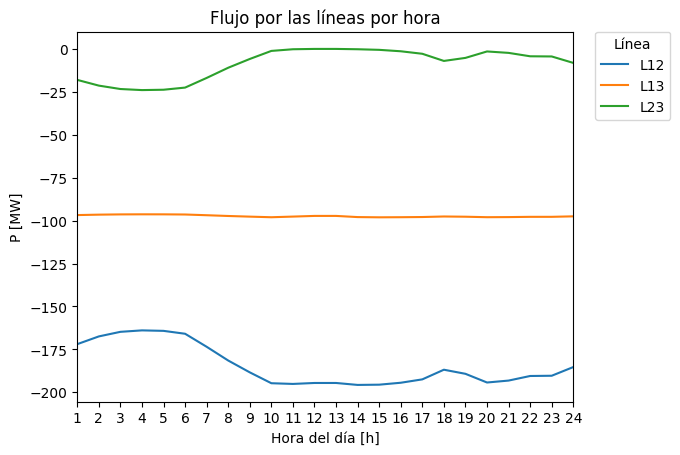

In [61]:
Pl_dia.plot()
plt.xlabel("Hora del día [h]")
plt.ylabel("P [MW]")
plt.xlim([1, 24])
# plt.ylim([None,0])
plt.xticks(list(range(1,25)))
plt.title("Flujo por las líneas por hora")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Línea")
plt.show()

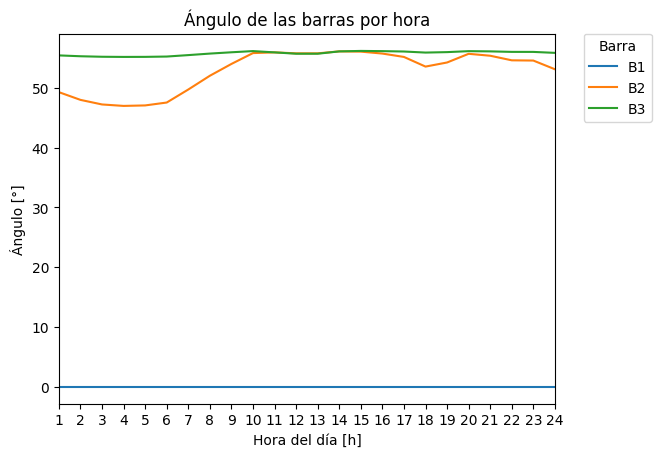

In [62]:
t_dia.plot()
plt.xlabel("Hora del día [h]")
plt.ylabel("Ángulo [°]")
plt.xlim([1, 24])
plt.xticks(list(range(1,25)))
plt.title("Ángulo de las barras por hora")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Barra")
plt.show()

# Análisis comparativo

## Generaciones

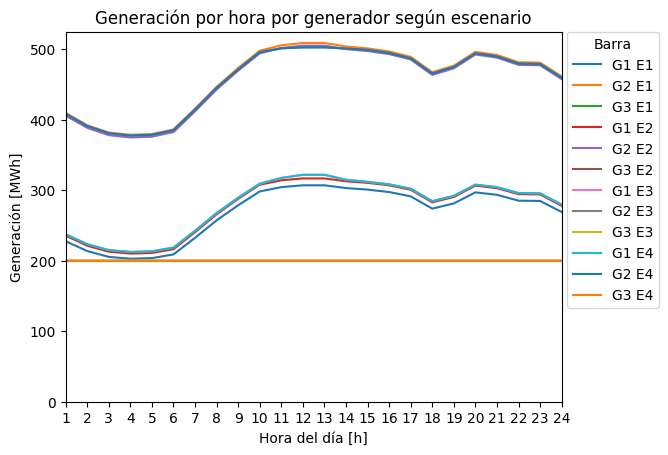

In [63]:
[plt.plot(Pg, label=["G1 E{}".format(idx + 1), "G2 E{}".format(idx + 1), "G3 E{}".format(idx + 1)]) for idx, Pg in enumerate(lista_Pg)]
plt.xlabel("Hora del día [h]")
plt.ylabel("Generación [MWh]")
plt.xlim([1, 24])
plt.ylim([0, None])
plt.xticks(list(range(1,25)))
plt.title("Generación por hora por generador según escenario")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Barra")
plt.show()

## Costo del sistema

### Escenarios 1, 2 y 3

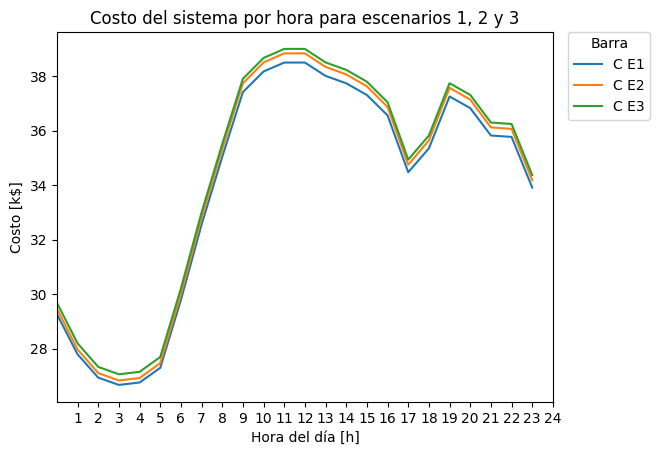

In [64]:
[plt.plot(C, label="C E{}".format(idx + 1)) for idx, C in enumerate(lista_C[:3])]
plt.xlabel("Hora del día [h]")
plt.ylabel("Costo [k$]")
plt.xlim([1, 24])
plt.xlim([0, None])
plt.xticks(list(range(1,25)))
plt.title("Costo del sistema por hora para escenarios 1, 2 y 3")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Barra")
plt.show()

### Todos los escenarios

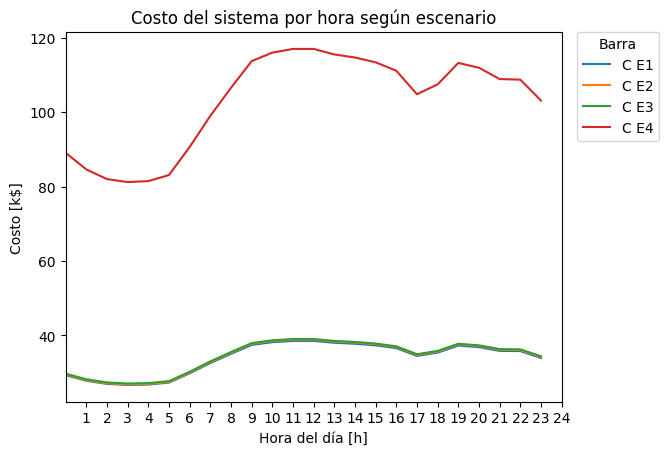

In [65]:
[plt.plot(C, label="C E{}".format(idx + 1)) for idx, C in enumerate(lista_C)]
plt.xlabel("Hora del día [h]")
plt.ylabel("Costo [k$]")
plt.xlim([1, 24])
plt.xlim([0, None])
plt.xticks(list(range(1,25)))
plt.title("Costo del sistema por hora según escenario")
plt.legend(bbox_to_anchor=(1.21, 1.02), loc="upper right", title="Barra")
plt.show()

## Costos marginales

### Escenarios 1, 2 y 3

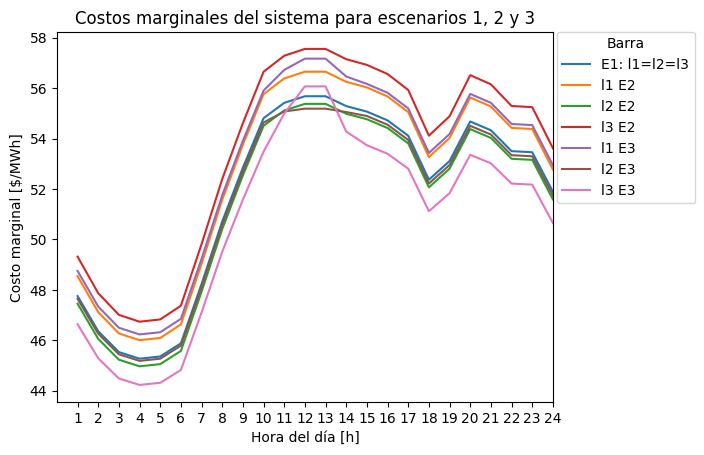

In [66]:
plt.plot(lista_ml[0]["l"], label = "E1: l1=l2=l3")
plt.plot(lista_ml[1][["l1", "l2", "l3"]], label = ["l1 E2", "l2 E2", "l3 E2"])
plt.plot(lista_ml[2][["l1", "l2", "l3"]], label = ["l1 E3", "l2 E3", "l3 E3"])
# plt.plot(lista_ml[3][["l1", "l2", "l3"]], label = ["l1 E4", "l2 E4", "l3 E4"])
plt.xlabel("Hora del día [h]")
plt.ylabel("Costo marginal [$/MWh]")
plt.xlim([1, 24])
plt.xlim([0, None])
plt.xticks(list(range(1,25)))
plt.title("Costos marginales del sistema para escenarios 1, 2 y 3")
plt.legend(bbox_to_anchor=(1.3, 1.02), loc="upper right", title="Barra")
plt.show()

### Todos los escenarios

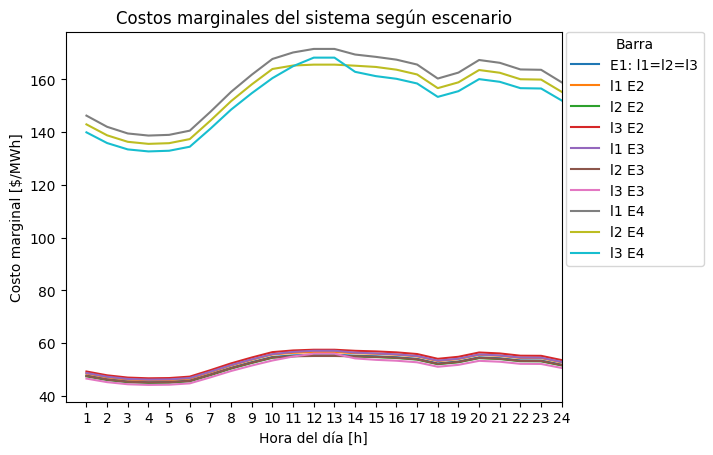

In [67]:
plt.plot(lista_ml[0]["l"], label = "E1: l1=l2=l3")
plt.plot(lista_ml[1][["l1", "l2", "l3"]], label = ["l1 E2", "l2 E2", "l3 E2"])
plt.plot(lista_ml[2][["l1", "l2", "l3"]], label = ["l1 E3", "l2 E3", "l3 E3"])
plt.plot(lista_ml[3][["l1", "l2", "l3"]], label = ["l1 E4", "l2 E4", "l3 E4"])
plt.xlabel("Hora del día [h]")
plt.ylabel("Costo marginal [$/MWh]")
plt.xlim([1, 24])
plt.xlim([0, None])
plt.xticks(list(range(1,25)))
plt.title("Costos marginales del sistema según escenario")
plt.legend(bbox_to_anchor=(1.3, 1.02), loc="upper right", title="Barra")
plt.show()

## Flujo por las líneas

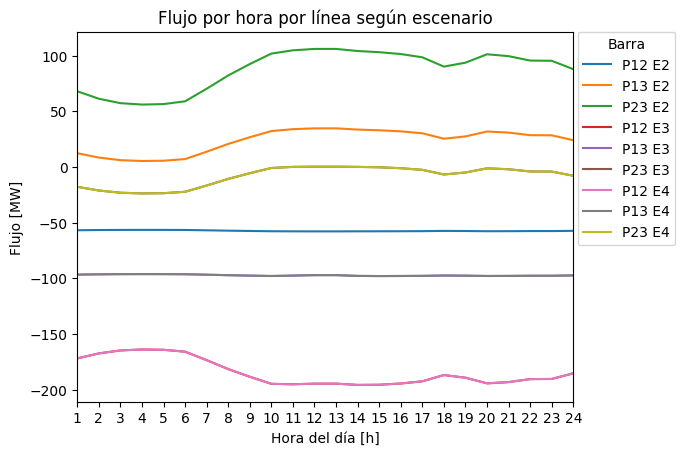

In [68]:
[plt.plot(Pl, label=["P12 E{}".format(idx + 2), "P13 E{}".format(idx + 2), "P23 E{}".format(idx + 2)]) for idx, Pl in enumerate(lista_Pl[1:])]
plt.xlabel("Hora del día [h]")
plt.ylabel("Flujo [MW]")
plt.xlim([1, 24])
# plt.ylim([0, None])
plt.xticks(list(range(1,25)))
plt.title("Flujo por hora por línea según escenario")
plt.legend(bbox_to_anchor=(1.22, 1.02), loc="upper right", title="Barra")
plt.show()